##In this notebook we will learn how to do the following:
1.   Print parameter gradients for each layer for a simple NN using torch functions
2.   Calculate gradients using Einstien's notation and check them against torch gradients
3.   Show how to write a custom loss function



In [0]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

# Lets write out some math
## The loss & forward function is defined by:
$$\text{Class label}: x,\hat{x}\in \mathbb{R}^2$$
$$\text{Input}: y\in \mathbb{R}^4$$
$$\text{Transition variables}: z,\sigma(z)\in \mathbb{R}^4$$

\begin{align}
\textbf{MSE Loss:} \quad L_{\theta}(\hat{x}) &= \frac{1}{K}\sum_{k=0}^{K-1}\frac{1}{2}||x_k- \hat{x}_k(\theta)||_2^2 \\
\text{For now batch size: } K &=1\\\\
\textbf{Fwd fun:} & \text{ Two-layer fully connected NN (ECE695: Week-4)}\\
\quad f_{\theta}&: y \to x\\
&\theta=[A\in\mathbb{R}^{4\text{x}4}, \quad B\in\mathbb{R}^{2\text{x}4}, \quad b\in\mathbb{R}^4]\\
z &=  Ay + b \quad  z\in \mathbb{R}^4\\
f_{\theta}(y)&= \hat{x} = B\sigma(Ay + b)\\
\text{where} \quad \sigma(z) &= \operatorname*{ReLU}(z) = \operatorname*{max}(0,z)
\end{align}

##The gradients are given by:
\begin{align}
\nabla_{\hat{x}}L &= -(x-\hat{x}) = \epsilon\\
\nabla_B f &= I\otimes\sigma(Ay+b)\\
\nabla_z \sigma &= \sum_{i=0}^{4-1} \frac{\sigma_i}{z_i} e_i\otimes e_i\\
\nabla_A f &= (B \nabla_z \sigma I) \otimes y  \\
\nabla_b f &= B \nabla_z \sigma I\\\\
\nabla_A L &= \epsilon  \nabla_A f \iff [\nabla_A f]^t\epsilon\\
\nabla_B L &= \epsilon  \nabla_B f \iff [\nabla_B f]^t\epsilon\\
\nabla_b L &= \epsilon  \nabla_b f \iff [\nabla_b f]^t\epsilon\\
\end{align}

In [0]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# initialize weights randomly
A = torch.rand(4,4, dtype=torch.float)
B = torch.rand(2,4, dtype=torch.float)
b = torch.rand(4,  dtype=torch.float)

y = torch.tensor([1,2,3,4],  dtype=torch.float).unsqueeze(0)
x_true = torch.tensor([0,1], dtype=torch.float).unsqueeze(0)

## (1) Print parameter gradients for each layer for a simple NN using torch functions

In [0]:
# the full torch way
class Torch_Net(nn.Module):
  """simple NN"""
  #TODO: see how to assign weights
  def __init__(self,in_features, out_features, A, B, b):
    super().__init__()
    linear1 = nn.Linear(in_features, 4, bias=True)
    linear1.weight= nn.Parameter(A)                 # assigned wts and bias should be of type nn.Parameter
    linear1.bias = nn.Parameter(b)
    linear2 = nn.Linear(4, out_features, bias=False)
    linear2.weight= nn.Parameter(B)
    self.linear1 = linear1
    self.linear2 = linear2

  def forward(self,y):
    x_hat = self.linear2(F.relu(self.linear1(y)))
    return(x_hat)

criterion = nn.MSELoss()
tor_net = Torch_Net(4,2,A,B,b)

x_hat_tor= tor_net(y)
loss_tor = criterion(x_hat_tor, x_true)
print('x_hat tor:\t'+str(x_hat_tor))
print('Loss:\t'+str(loss_tor))
#compute the gradients
# print(loss_tor.grad)
loss_tor.backward()
# print(loss_tor.grad)
# print gradients:
print('------- Wt gradients --------')
print('grad_B L:\n'+ str(tor_net.linear2.weight.grad))
print('grad_A L:\n'+ str(tor_net.linear1.weight.grad))
print('grad_b L:\n'+ str(tor_net.linear1.bias.grad))

x_hat tor:	tensor([[ 9.8160, 13.8328]], grad_fn=<MmBackward>)
Loss:	tensor(130.5176, grad_fn=<MseLossBackward>)
------- Wt gradients --------
grad_B L:
tensor([[31.8594, 70.5235, 52.2852, 32.9028],
        [41.6510, 92.1980, 68.3544, 43.0151]])
grad_A L:
tensor([[15.5953, 31.1905, 46.7858, 62.3811],
        [19.5974, 39.1949, 58.7923, 78.3897],
        [ 6.6766, 13.3532, 20.0297, 26.7063],
        [13.9886, 27.9773, 41.9659, 55.9545]])
grad_b L:
tensor([15.5953, 19.5974,  6.6766, 13.9886])


## (2) Calculate gradients using Einstien's notation and check them against torch gradients

In [0]:
# my forward calculation:
Ay = torch.matmul(A,y[0]) # not concerned about batch
z = Ay +b
sigma = F.relu(z)
x_hat = torch.matmul(B,sigma)
print('x_hat:\t'+str(x_hat))
print('Loss:\t'+str(0.5*torch.norm(x_true-x_hat)**2))

# my backward calculations
print('------- Wt gradients --------')
# grad of loss wrt x_hat
error = -(x_true[0]-x_hat)

# linear 2 wt grad
# first solve I\otimes\sigma(Ay+b): outer product
# torch does not have an alternate to einsum when computing outerproduct of tensors (torch.ger() is only good for two vectors)
grad_B = torch.einsum('ij,k->ijk',torch.eye(2),sigma) # fwd gradient
# \nabla_B = epsilon grad_B
grad_B = torch.matmul(error,grad_B)           
print( 'grad_B L:\n'+ str(grad_B))
print('grad_B torch vs me:\t'+ str(torch.norm(tor_net.linear2.weight.grad - grad_B))+'\n')

# linear 1 wt grad
grad_sigma = torch.diag(torch.div(sigma,z))
grad_A = torch.matmul(B, grad_sigma)
grad_A = torch.matmul(grad_A, torch.eye(4))
grad_A = torch.einsum('ij,k-> ijk', grad_A, y[0]) # fwd gradient
grad_A1 = torch.einsum('i,ijk->jk',error, grad_A)   
#or
grad_A2 = grad_A.transpose(0,2).transpose(0,1) # adjoint gradient
grad_A2 = torch.matmul(grad_A2,error)
print('grad_A L:\n '+str(grad_A2))
print('fwd vs adjoint:\t'+str(torch.norm(grad_A1-grad_A2)))
print('grad_A torch vs me:\t'+ str(torch.norm(tor_net.linear1.weight.grad - grad_A2))+'\n')

# linear 1 bias grad
grad_b = torch.matmul(B, grad_sigma)
grad_b = torch.matmul(grad_b, torch.eye(4))
grad_b = grad_b.transpose(0,1) # adjoint gradient
grad_b = torch.matmul(grad_b, error)
print('grad_b L:\n'+str(grad_b))
print('grad_b torch vs me:\t'+ str(torch.norm(tor_net.linear1.bias.grad - grad_b))+'\n')

x_hat:	tensor([ 9.8160, 13.8328])
Loss:	tensor(130.5176)
------- Wt gradients --------
grad_B L:
tensor([[31.8594, 70.5235, 52.2852, 32.9028],
        [41.6510, 92.1980, 68.3544, 43.0151]])
grad_B torch vs me:	tensor(0.)

grad_A L:
 tensor([[15.5953, 31.1905, 46.7858, 62.3811],
        [19.5974, 39.1949, 58.7923, 78.3897],
        [ 6.6766, 13.3532, 20.0297, 26.7063],
        [13.9886, 27.9773, 41.9659, 55.9545]])
fwd vs adjoint:	tensor(0.)
grad_A torch vs me:	tensor(6.1251e-06)

grad_b L:
tensor([15.5953, 19.5974,  6.6766, 13.9886])
grad_b torch vs me:	tensor(0.)



## (3) How to write custom loss function

In [0]:
# Custom Loss function: 
class Torch_MSELoss(nn.Module):
  """ MSELoss using torch constructs: no need to define backward """
  def __init__(self):
    super().__init__()

  def forward(self,inputs,targets):
    B = inputs.shape[0] 
    loss = inputs- targets
    loss = (1/(2*B))*torch.sum(torch.pow(loss,2))
    return loss

class NoBackward_MSELoss(nn.Module):
  """ MSELoss w/o torch constructs w/o backward"""
  def __init__(self):
    super().__init__()
      
  def forward(self,inputs,targets):
    inputs = inputs.detach().cpu().numpy()
    targets= targets.detach().cpu().numpy()
    B = inputs.shape[0] 
    loss = targets - inputs
    loss = (1/(2*B))*np.sum(np.power(loss,2))
    return(torch.autograd.Variable(torch.from_numpy(np.array([loss]))))

class My_MSELoss(torch.autograd.Function):
  """ MSELoss w/o torch constructs with backward """
  def __init__(self):
    super().__init__()
  
  @staticmethod
  def forward(ctx,inputs,targets):
    inputs = inputs.detach().cpu().numpy()
    targets= targets.detach().cpu().numpy()
    B = inputs.shape[0] 
    loss = targets -inputs
    ctx.save_for_backward(torch.from_numpy(loss))
    loss = (1/(2*B))*np.sum(np.power(loss,2))
    return(torch.autograd.Variable(torch.Tensor([loss])))
  
  @staticmethod
  def backward(ctx,grad_output):
    diff, = ctx.saved_tensors
    diff = diff.detach().cpu().numpy()
    B = diff.shape[0]
    grad_input = -(1/B)*np.sum(diff,axis=0)
    return(torch.from_numpy(grad_input).unsqueeze(0),None)

torch_constructs_MSELoss = Torch_MSELoss()
noBack_MSELoss = NoBackward_MSELoss()
my_MSELoss = My_MSELoss.apply

# zero the gradients
tor_net.linear2.weight.grad.zero_()
tor_net.linear1.weight.grad.zero_()
tor_net.linear1.bias.grad.zero_()
print('------- Wt gradients --------')
print('Zeroing the gradients\n')
print('grad_B L:\n'+ str(tor_net.linear2.weight.grad))
print('grad_A L:\n'+ str(tor_net.linear1.weight.grad))
print('grad_b L:\n'+ str(tor_net.linear1.bias.grad))


------- Wt gradients --------
Zeroing the gradients

grad_B L:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.]])
grad_A L:
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
grad_b L:
tensor([0., 0., 0., 0.])


In [0]:
x_hat_new = tor_net(y)
tor_loss = torch_constructs_MSELoss(x_hat_new, x_true)
print(tor_loss)
tor_loss.backward()
print('------- Wt gradients --------')
print('grad_B L:\n'+ str(tor_net.linear2.weight.grad))
print('grad_A L:\n'+ str(tor_net.linear1.weight.grad))
print('grad_b L:\n'+ str(tor_net.linear1.bias.grad))

tensor(130.5176, grad_fn=<MulBackward0>)
------- Wt gradients --------
grad_B L:
tensor([[31.8594, 70.5235, 52.2852, 32.9028],
        [41.6510, 92.1980, 68.3544, 43.0151]])
grad_A L:
tensor([[15.5953, 31.1905, 46.7858, 62.3811],
        [19.5974, 39.1949, 58.7923, 78.3897],
        [ 6.6766, 13.3532, 20.0297, 26.7063],
        [13.9886, 27.9773, 41.9659, 55.9545]])
grad_b L:
tensor([15.5953, 19.5974,  6.6766, 13.9886])


In [0]:
x_hat_new = tor_net(y)
numpy_My_loss = my_MSELoss(x_hat_new, x_true)
print(numpy_My_loss)
# zero the gradients
tor_net.linear2.weight.grad.zero_()
tor_net.linear1.weight.grad.zero_()
tor_net.linear1.bias.grad.zero_()

numpy_My_loss.backward()
print('------- Wt gradients --------')
print('grad_B L:\n'+ str(tor_net.linear2.weight.grad))
print('grad_A L:\n'+ str(tor_net.linear1.weight.grad))
print('grad_b L:\n'+ str(tor_net.linear1.bias.grad))

tensor([130.5176], grad_fn=<My_MSELossBackward>)
------- Wt gradients --------
grad_B L:
tensor([[31.8594, 70.5235, 52.2852, 32.9028],
        [41.6510, 92.1980, 68.3544, 43.0151]])
grad_A L:
tensor([[15.5953, 31.1905, 46.7858, 62.3811],
        [19.5974, 39.1949, 58.7923, 78.3897],
        [ 6.6766, 13.3532, 20.0297, 26.7063],
        [13.9886, 27.9773, 41.9659, 55.9545]])
grad_b L:
tensor([15.5953, 19.5974,  6.6766, 13.9886])


In [0]:
x_hat_new = tor_net(y)

noBack_numpy_loss = noBack_MSELoss(x_hat_new, x_true)
print(noBack_numpy_loss)

# zero the gradients
tor_net.linear2.weight.grad.zero_()
tor_net.linear1.weight.grad.zero_()
tor_net.linear1.bias.grad.zero_()

noBack_numpy_loss.backward()
print('------- Wt gradients --------')
print('grad_B L:\n'+ str(tor_net.linear2.weight.grad))
print('grad_A L:\n'+ str(tor_net.linear1.weight.grad))
print('grad_b L:\n'+ str(tor_net.linear1.bias.grad))

tensor([130.5176], dtype=torch.float64)


RuntimeError: ignored

# Take-Aways:
1.    Einstein's Notation comes handy in explicity writing the gradient
2.    When writing custom functions always try to use only torch constructs. This way you can get away with not writing the backward function
3.    If you need to use non-torch constructs for your function, you need to write out the backwards function. In this case subclassing the ***torch.autograd.Function()*** is the way to go.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


(-0.5, 676.5, 368.5, -0.5)

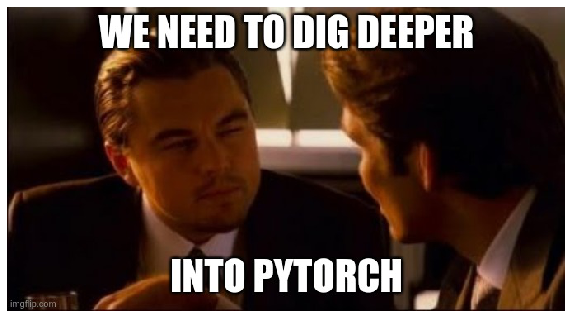

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/gdrive')
img = plt.imread('./gdrive/My Drive/ECE695_DL/Recreational/3rmpt0.jpg')
plt.rcParams['figure.figsize'] = [10,10]
plt.imshow(img)
plt.axis('off')